# Analysis of DNA-MERFISH for CTP11

by Pu Zheng

2022.02.15

analysis for dataset:

\\10.245.74.158\Chromatin_NAS_0\20220215-P_brain_CTP11-1000_CTP12_from0208

This data is DNA of uncleared MERFISH RNA:
    \\10.245.74.158\Chromatin_NAS_0\20220208-P_brain_M1_nonclear


In [1]:
%run "..\..\Startup_py3.py"
sys.path.append(r"..\..\..\..\Documents")

import ImageAnalysis3 as ia
%matplotlib notebook

from ImageAnalysis3 import *
print(os.getpid())

import h5py
from ImageAnalysis3.classes import _allowed_kwds
import ast

3620


# 1. Pre-processing info

In [3]:
fov_param = {'data_folder':r'\\10.245.74.158\Chromatin_NAS_0\20220215-P_brain_CTP11-1000_CTP12_from0208',
             'save_folder':r'\\mendel\Mendel_SSD1\Pu_Temp\20220215-P_brain_CTP11-1000_CTP12_from0208',
             'experiment_type': 'DNA',
             'num_threads': 25,
             'correction_folder':r'\\10.245.74.158\Chromatin_NAS_0\Corrections\20210621-Corrections_lumencor_from_60_to_50',
             'shared_parameters':{
                     'single_im_size':[50,2048,2048],
                     'distance_zxy': [250, 108, 108],
                     'corr_channels':['750','647'],
                     'num_empty_frames': 0, 
                     'num_buffer_frames':0,
                     'corr_hot_pixel':True,
                     'corr_Z_shift':True,
                     'corr_bleed':True,
                     'min_num_seeds':10,
                     'max_num_seeds': None,
                     'spot_seeding_th': 1000,
                     'normalize_intensity_local':False,
                     'normalize_intensity_background':False,
                     'corr_gaussian_highpass':False
                 }, 
             }

## 1.1 define required floders

In [24]:
save_folder = fov_param['save_folder']

save_filenames = [os.path.join(save_folder, _fl) for _fl in os.listdir(save_folder)
                  if _fl.split(os.extsep)[-1]=='hdf5']
# extract fov_id
save_fov_ids = [int(os.path.basename(_fl).split('.hdf5')[0].split('_')[-1]) for _fl in save_filenames]

debug = False

print(f"{len(save_filenames)} fovs detected")

segmentation_folder = os.path.join(save_folder, 'Segmentation', 'Tests')
if not os.path.exists(segmentation_folder):
    os.makedirs(segmentation_folder)
    print(f"Creating segmentation_folder: {segmentation_folder}")
else:
    print(f"Use segmentation_folder: {segmentation_folder}")

cand_spot_folder = os.path.join(save_folder, 'CandSpots', 'Tests')
if not os.path.exists(cand_spot_folder):
    os.makedirs(cand_spot_folder)
    print(f"Creating cand_spot_folder: {cand_spot_folder}")
else:
    print(f"Use cand_spot_folder: {cand_spot_folder}")

decoder_folder = cand_spot_folder.replace('CandSpots', 'Decoder')
if debug:
    _version = 0
    while os.path.exists(os.path.join(decoder_folder, f'v{_version}')):
        _version += 1
    decoder_folder = os.path.join(decoder_folder, f'v{_version}')
if not os.path.exists(decoder_folder):
    os.makedirs(decoder_folder)
    print(f"Creating decoder_folder: {decoder_folder}")
else:
    print(f"Use decoder_folder: {decoder_folder}")


127 fovs detected
Use segmentation_folder: \\mendel\Mendel_SSD1\Pu_Temp\20220215-P_brain_CTP11-1000_CTP12_from0208\Segmentation\Tests
Use cand_spot_folder: \\mendel\Mendel_SSD1\Pu_Temp\20220215-P_brain_CTP11-1000_CTP12_from0208\CandSpots\Tests
Use decoder_folder: \\mendel\Mendel_SSD1\Pu_Temp\20220215-P_brain_CTP11-1000_CTP12_from0208\Decoder\Tests


In [25]:
pixel_sizes = np.array(fov_param['shared_parameters']['distance_zxy'])
single_im_size = np.array(fov_param['shared_parameters']['single_im_size'])
intensity_th = np.array(fov_param['shared_parameters']['spot_seeding_th'])

In [26]:
save_fov_ids = save_fov_ids[:120]
save_filenames = save_filenames[:120]

# 2. Partiton spots into cells

## 2.1 (For DNA-only) run segmentation

## (For DNA after dense MERFISH)

In [27]:
# MERFISH segmentation
merfish_segmentation_folder = r'\\mendel\Mendel_SSD3\MERFISH_Analysis\Cellpose\20220208-P_brain_M1_nonclear\CellPoseSegment\features'
merfish_dapi_folder = r'\\10.245.74.158\Chromatin_NAS_0\20220208-P_brain_M1_nonclear\Segmentation_Cellpose'
# generate alignment
rna_data_folder = r'\\10.245.74.158\Chromatin_NAS_0\20220208-P_brain_M1_nonclear'
rna_alignment_file = os.path.join(rna_data_folder, 'Alignment', '10x_positions_before.txt')
dna_alignment_file = os.path.join(fov_param['data_folder'], 'Alignment', '10x_positions_after.txt')
print(os.path.exists(rna_alignment_file), os.path.exists(dna_alignment_file))
R, t = ia.correction_tools.alignment.align_manual_points(rna_alignment_file, dna_alignment_file,
                                                         save_folder=save_folder)

True True
- Manually picked points aligned, rotation:
[[ 0.99989048 -0.01479949]
 [ 0.01479949  0.99989048]],
 translation:[   50.27017055 -1393.00834786]
-- rotation matrix saved to file:\\mendel\Mendel_SSD1\Pu_Temp\20220215-P_brain_CTP11-1000_CTP12_from0208\rotation
-- translation matrix saved to file:\\mendel\Mendel_SSD1\Pu_Temp\20220215-P_brain_CTP11-1000_CTP12_from0208\translation


In [129]:
reload(ia.correction_tools.alignment)
reload(ia.segmentation_tools.cell)
from ImageAnalysis3.segmentation_tools.cell import Align_Segmentation

In [101]:
microscope_file = r'\\mendel\pu_documents\Merfish_analysis\Merfish_Analysis_Scripts\merlin_parameters\microscope\storm6_microscope.json'
Zcoords = np.arange(0,12.5,0.25)

_total_seg_save_file = os.path.join(segmentation_folder, 'full_segmentation.hdf5')

In [ ]:
%%time

reload(ia.correction_tools.alignment)
reload(ia.segmentation_tools.cell)
from ImageAnalysis3.segmentation_tools.cell import Align_Segmentation
for _fov_id, _save_filename in zip(save_fov_ids, save_filenames):
    if _fov_id ==0:
        continue
    # segmentation filename
    _segmentation_filename = os.path.join(segmentation_folder, 
        os.path.basename(_save_filename).replace('.hdf5', '_Segmentation.npy') )
    _rna_feature_filename = os.path.join(merfish_segmentation_folder, f"feature_data_{_fov_id}.hdf5")
    _rna_dapi_filename = os.path.join(merfish_dapi_folder, 
                                      os.path.basename(_save_filename).replace('.hdf5', '_Dapi.npy'))
    
    _dna_mask = _batch_align_segmentation(
        _fov_id, Zcoords,
        rna_feature_file=_rna_feature_filename, 
        rna_dapi_file=_rna_dapi_filename,
        dna_save_file=_save_filename,
        microscope_file=microscope_file, 
        rotation_mat=R,
        segmentation_save_file=_total_seg_save_file,
        save=True,
        overwrite=False,
    )

-- loading segmentation info from fov:1 into file: \\mendel\Mendel_SSD1\Pu_Temp\20220215-P_brain_CTP11-1000_CTP12_from0208\Segmentation\Tests\full_segmentation.hdf5
True
-- loading segmentation info from fov:2 into file: \\mendel\Mendel_SSD1\Pu_Temp\20220215-P_brain_CTP11-1000_CTP12_from0208\Segmentation\Tests\full_segmentation.hdf5
False
- reconstruct 50 layers
-- start calculating drift with rotation between images
-- start aligning given source image to given reference image.
-- aligned image 0 in 0.921s.
-- aligned image 1 in 0.937s.
-- aligned image 2 in 0.906s.
-- aligned image 3 in 0.906s.
-- aligned image 4 in 0.953s.
-- aligned image 5 in 0.906s.
-- aligned image 6 in 0.938s.
-- aligned image 7 in 0.922s.
-- return a sub-optimal drift
--- drift: [ -0.47  -6.57 -20.57] pixels
- generate rotation matrix
- rotate segmentation label with rotation matrix
-- saving segmentation info from fov:2 into file: \\mendel\Mendel_SSD1\Pu_Temp\20220215-P_brain_CTP11-1000_CTP12_from0208\Segment

-- aligned image 2 in 0.875s.
-- aligned image 3 in 0.922s.
-- aligned image 4 in 0.891s.
-- aligned image 5 in 0.906s.
-- aligned image 6 in 0.922s.
-- aligned image 7 in 0.891s.
--- drifts for crops:[1 5 7] pass the thresold, exit cycle.
--- drift: [ -0.27  -1.6  -50.7 ] pixels
- generate rotation matrix
- rotate segmentation label with rotation matrix
-- saving segmentation info from fov:11 into file: \\mendel\Mendel_SSD1\Pu_Temp\20220215-P_brain_CTP11-1000_CTP12_from0208\Segmentation\Tests\full_segmentation.hdf5
-- loading segmentation info from fov:12 into file: \\mendel\Mendel_SSD1\Pu_Temp\20220215-P_brain_CTP11-1000_CTP12_from0208\Segmentation\Tests\full_segmentation.hdf5
False
- reconstruct 50 layers
-- start calculating drift with rotation between images
-- start aligning given source image to given reference image.
-- aligned image 0 in 0.924s.
-- aligned image 1 in 0.888s.
-- aligned image 2 in 0.906s.
-- aligned image 3 in 0.922s.
-- aligned image 4 in 0.891s.
-- aligned im

- reconstruct 50 layers
-- start calculating drift with rotation between images
-- start aligning given source image to given reference image.
-- aligned image 0 in 0.875s.
-- aligned image 1 in 0.938s.
-- aligned image 2 in 0.891s.
-- aligned image 3 in 0.922s.
-- aligned image 4 in 0.891s.
-- aligned image 5 in 0.922s.
-- aligned image 6 in 0.922s.
-- aligned image 7 in 0.891s.
-- return a sub-optimal drift
--- drift: [ -0.27  -0.07 -48.63] pixels
- generate rotation matrix
- rotate segmentation label with rotation matrix
-- saving segmentation info from fov:21 into file: \\mendel\Mendel_SSD1\Pu_Temp\20220215-P_brain_CTP11-1000_CTP12_from0208\Segmentation\Tests\full_segmentation.hdf5
-- loading segmentation info from fov:22 into file: \\mendel\Mendel_SSD1\Pu_Temp\20220215-P_brain_CTP11-1000_CTP12_from0208\Segmentation\Tests\full_segmentation.hdf5
False
- reconstruct 50 layers
-- start calculating drift with rotation between images
-- start aligning given source image to given referen

-- saving segmentation info from fov:30 into file: \\mendel\Mendel_SSD1\Pu_Temp\20220215-P_brain_CTP11-1000_CTP12_from0208\Segmentation\Tests\full_segmentation.hdf5
-- loading segmentation info from fov:31 into file: \\mendel\Mendel_SSD1\Pu_Temp\20220215-P_brain_CTP11-1000_CTP12_from0208\Segmentation\Tests\full_segmentation.hdf5
False
- reconstruct 50 layers
-- start calculating drift with rotation between images
-- start aligning given source image to given reference image.
-- aligned image 0 in 0.881s.
-- aligned image 1 in 0.862s.
-- aligned image 2 in 0.878s.
-- aligned image 3 in 0.894s.
--- drifts for crops:[1 2 3] pass the thresold, exit cycle.
--- drift: [ -0.27  -0.2  -46.57] pixels
- generate rotation matrix
- rotate segmentation label with rotation matrix
-- saving segmentation info from fov:31 into file: \\mendel\Mendel_SSD1\Pu_Temp\20220215-P_brain_CTP11-1000_CTP12_from0208\Segmentation\Tests\full_segmentation.hdf5
-- loading segmentation info from fov:32 into file: \\mend

-- aligned image 3 in 0.896s.
-- aligned image 4 in 0.894s.
-- aligned image 5 in 0.914s.
-- aligned image 6 in 0.894s.
-- aligned image 7 in 0.909s.
-- return a sub-optimal drift
--- drift: [ -0.3   10.33 -11.87] pixels
- generate rotation matrix
- rotate segmentation label with rotation matrix
-- saving segmentation info from fov:40 into file: \\mendel\Mendel_SSD1\Pu_Temp\20220215-P_brain_CTP11-1000_CTP12_from0208\Segmentation\Tests\full_segmentation.hdf5
-- loading segmentation info from fov:41 into file: \\mendel\Mendel_SSD1\Pu_Temp\20220215-P_brain_CTP11-1000_CTP12_from0208\Segmentation\Tests\full_segmentation.hdf5
False
- reconstruct 50 layers
-- start calculating drift with rotation between images
-- start aligning given source image to given reference image.
-- aligned image 0 in 0.847s.
-- aligned image 1 in 0.883s.
-- aligned image 2 in 0.896s.
-- aligned image 3 in 0.878s.
-- aligned image 4 in 0.862s.
-- aligned image 5 in 0.883s.
-- aligned image 6 in 0.884s.
-- aligned im

-- loading segmentation info from fov:50 into file: \\mendel\Mendel_SSD1\Pu_Temp\20220215-P_brain_CTP11-1000_CTP12_from0208\Segmentation\Tests\full_segmentation.hdf5
False
- reconstruct 50 layers
-- start calculating drift with rotation between images
-- start aligning given source image to given reference image.
-- aligned image 0 in 0.909s.
-- aligned image 1 in 0.847s.
-- aligned image 2 in 0.862s.
-- aligned image 3 in 0.896s.
-- aligned image 4 in 0.862s.
-- aligned image 5 in 0.909s.
-- aligned image 6 in 0.890s.
-- aligned image 7 in 0.894s.
-- return a sub-optimal drift
--- drift: [-0.37 11.63 -4.17] pixels
- generate rotation matrix
- rotate segmentation label with rotation matrix
-- saving segmentation info from fov:50 into file: \\mendel\Mendel_SSD1\Pu_Temp\20220215-P_brain_CTP11-1000_CTP12_from0208\Segmentation\Tests\full_segmentation.hdf5
-- loading segmentation info from fov:51 into file: \\mendel\Mendel_SSD1\Pu_Temp\20220215-P_brain_CTP11-1000_CTP12_from0208\Segmentation

In [20]:
_dna_mask = _align_seg._generate_dna_mask()

- reconstruct 50 layers
-- start calculating drift with rotation between images
-- start aligning given source image to given reference image.
-- aligned image 0 in 0.921s.
-- aligned image 1 in 0.938s.
-- aligned image 2 in 0.953s.
-- aligned image 3 in 0.938s.
-- aligned image 4 in 0.938s.
-- aligned image 5 in 0.937s.
-- aligned image 6 in 0.937s.
-- aligned image 7 in 0.922s.
-- return a sub-optimal drift
--- drift: [  6.53  27.53 -26.23] pixels
- generate rotation matrix
- rotate segmentation label with rotation matrix


In [ ]:
_align_seg._save(_segmentation_filename)

In [ ]:
%matplotlib inline
# translate given_id into
from ImageAnalysis3.segmentation_tools.cell import translate_segmentation
from ImageAnalysis3.figure_tools import plot_segmentation
from ImageAnalysis3.segmentation_tools.cell import interploate_z_masks

from scipy.ndimage import grey_dilation

dialation_dimension = 4
overwrite_segmentation = False

_fovcell_2_uid = {}
_fov_2_Zcoords = {}

for _fov_id, _save_filename in zip(save_fov_ids, save_filenames):
    
    # segmentation filename
    segmentation_filename = os.path.join(segmentation_folder, 
        os.path.basename(_save_filename).replace('.hdf5', '_Segmentation.npy') )
    
    if os.path.exists(segmentation_filename) and not overwrite_segmentation:
        print(f"directly load segmentation from file: {segmentation_filename}")
        dna_mask = np.load(segmentation_filename)
    else:
        print(f"translate segmentation of fov-{_fov_id} from MERFISH")
        # Load DAPI
        with h5py.File(_save_filename, "r", libver='latest') as _f:
            _fov_name = _f.attrs['fov_name']
            # load DAPI
            dapi_im = _f.attrs['dapi_im']
        # Load RNA-feature
        _rna_feature_filename = os.path.join(merfish_segmentation_folder, f"feature_data_{_fov_id}.hdf5")
        # get z_coordinates
        _z_coords = np.arange(13) # default
        with h5py.File(_rna_feature_filename, 'r') as _f:
            _label_group = _f['labeldata']
            rna_mask = _label_group['label3D'][:]
            rna_mask = np.flip(rna_mask.transpose((0,2,1)), 2)
            # load feature info
            _feature_group = _f['featuredata']
            for _cell_uid in _feature_group.keys():
                _cell_group = _feature_group[_cell_uid]
                _z_coords = _cell_group['z_coordinates'][:]
                _fovcell_2_uid[(_cell_group.attrs['fov'], _cell_group.attrs['label'])] = _cell_uid

        _fov_2_Zcoords[_fov_id] = _z_coords
        # reconstruct full mask
        rna_full_mask = interploate_z_masks(rna_mask, _fov_2_Zcoords[_fov_id],
                                        np.round(np.arange(0,12.5,0.25),2), )

        rna_dapi_filename = os.path.join(merfish_dapi_folder, 
                                         _fov_name.replace('.dax', '_Dapi.npy'))
        rna_dapi_im = np.load(rna_dapi_filename)

        # Align
        dna_mask, rot_dapi_im = translate_segmentation(rna_dapi_im, dapi_im, R, 
                                                       label_before=rna_full_mask, return_new_dapi=True)
        # Do dialation
        dna_mask = grey_dilation(dna_mask, size=dialation_dimension)
        dna_mask[dna_mask==0] = -1
        # Save
        print(f"Save segmentation to :{segmentation_filename}")
        np.save(segmentation_filename.replace('.npy',''), dna_mask)
        
    # Make plot
    mask_savefig = os.path.join(segmentation_folder, 'Figures', 
                                os.path.basename(_save_filename).replace('.hdf5', '_SegmentationMask.png'))
    if not os.path.exists(os.path.dirname(mask_savefig)):
        os.makedirs(os.path.dirname(mask_savefig))
    ax = plot_segmentation.plot_segmentation(dna_mask, save_filename=mask_savefig)
    
    

<IPython.core.display.Javascript object>


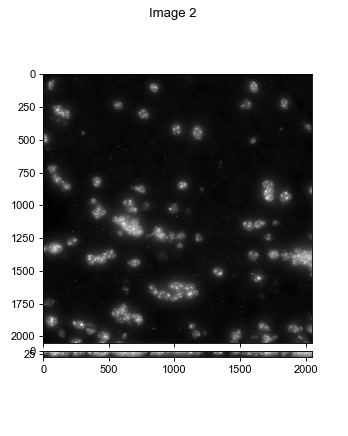

In [84]:
%matplotlib notebook
# visually check
visual_tools.imshow_mark_3d_v2([dna_mask, dapi_im, rot_dapi_im, rna_dapi_im, new_full_mask])

15521

In [96]:
# save
print(len(_fovcell_2_uid))
pickle.dump(_fovcell_2_uid, open(os.path.join(segmentation_folder, f'fovcell_2_uid.pkl'),'wb'))

15521


## 2.2 Partition spots

In [97]:
from ImageAnalysis3.meta_tools.partition_spots import Spots_Partition
reload(ia.meta_tools.partition_spots)
from ImageAnalysis3.classes.preprocess import Spots3D

from ImageAnalysis3.figure_tools import plot_partition

import pandas as pd

In [ ]:
%%time
%matplotlib inline

search_radius = 3
overwrite_cand_spots = False

# create all info
fov_2_spots_df = {}

for _fov_id, _save_filename in zip(save_fov_ids, save_filenames):
    # segmentation 
    segmentation_filename = os.path.join(segmentation_folder, 
        os.path.basename(_save_filename).replace('.hdf5', '_Segmentation.npy') )
    print(f"Load Segmentation from file: {segmentation_filename}")
    seg_label = np.load(segmentation_filename)
    # savename
    cand_spot_filename = os.path.join(cand_spot_folder,
                                      os.path.basename(_save_filename).replace('.hdf5', f'_CandSpots.csv') )
    if os.path.exists(cand_spot_filename) and not overwrite_cand_spots:
        print(f"Directly load cand_spots from file: {cand_spot_filename}")
        fov_2_spots_df[_fov_id] = pd.read_csv(cand_spot_filename)
        
    else:
        print(f"Partition spots for fov-{_fov_id}")

        ## Load spots and their info
        with h5py.File(_save_filename, "r", libver='latest') as _f:
            _grp = _f['combo']
            combo_spots_list = [_spots[_spots[:,0]>0] for _spots in _grp['spots'][:]]
            raw_combo_spots_list = [_spots[_spots[:,0]>0] for _spots in _grp['raw_spots'][:]]
            combo_channels = [_ch.decode() for _ch in _grp['channels'][:]]
            combo_ids = _grp['ids'][:]

        ## partition
        cell_2_spots = {_c:{} for _c in np.arange(1, np.max(seg_label)+1)}
        cell_2_raw_spots = {_c:{} for _c in np.arange(1, np.max(seg_label)+1)}
        label_dict = {}

        for _id, _pts, _raw_pts in zip(combo_ids, combo_spots_list, raw_combo_spots_list):
            # cast spot class
            _spots = Spots3D(_pts, bits=_id, pixel_sizes=pixel_sizes)
            _raw_spots = Spots3D(_pts, bits=_id, pixel_sizes=pixel_sizes)
            # calculate labels
            _labels = Spots_Partition.spots_to_labels(seg_label, _spots, search_radius=search_radius)
            label_dict[_id] = _labels
            # parittion
            for _l in np.unique(_labels):
                if _l > 0:
                    _keep_flags = (_labels==_l)
                    # append
                    cell_2_spots[_l][_id] = _spots[_keep_flags]
                    cell_2_spots[_l][_id].bits = _spots.bits[_keep_flags]
                    cell_2_raw_spots[_l][_id] = _raw_spots[_keep_flags]
                    cell_2_raw_spots[_l][_id].bits = _raw_spots.bits[_keep_flags]
        ## plot stats
        cell_spots_counts = []
        for _cell, _spots_dict in cell_2_spots.items():
            _spots_counts = []
            for _bit in combo_ids:
                if _bit in _spots_dict:
                    _spots_counts.append(len(_spots_dict[_bit]))
                else:
                    _spots_counts.append(0)
            cell_spots_counts.append(np.array(_spots_counts))
        cell_spots_counts = np.array(cell_spots_counts)

        count_savefig = os.path.join(cand_spot_folder, 'Figures', 
                                     os.path.basename(_save_filename).replace('.hdf5', '_SpotCountPerCell.png'))
        if not os.path.exists(os.path.dirname(count_savefig)):
            os.makedirs(os.path.dirname(count_savefig))
        # Plot
        count_ax = plot_partition.plot_cell_spot_counts(cell_spots_counts, save=True, save_filename=count_savefig)

        from ImageAnalysis3.io_tools.spots import FovCell2Spots_2_DataFrame
        # bit_2_channel
        bit_2_channel = {_b:_ch for _b,_ch in zip(combo_ids, combo_channels)}

        spots_df = FovCell2Spots_2_DataFrame(cell_2_spots, _fov_id, bit_2_channel, _fovcell_2_uid,
                                             save_filename=cand_spot_filename)

        # append
        fov_2_spots_df[_fov_id] = spots_df
        

In [11]:
%%time
# decide fovs to merge
merge_fov_ids = save_fov_ids #[1,2,3,4]
merged_spots_df = pd.DataFrame([], columns=fov_2_spots_df[merge_fov_ids[0]].columns)
for _fov_id in merge_fov_ids:
    merged_spots_df = merged_spots_df.append(fov_2_spots_df[merge_fov_ids[_fov_id]], ignore_index=True )

Wall time: 25.1 s


In [12]:
merged_spots_df

,fov_id,cell_id,height,z,x,y,background,sigma_z,sigma_x,sigma_y,sin_t,sin_p,eps,bit,channel,pixel_z,pixel_x,pixel_y
0,0,1,8202.493164,9.285052,89.580498,72.475677,16403.648438,1.803174,1.799484,1.985787,-1.000000,1.000000,951.284668,1,750,250,108,108
1,0,1,7974.637695,6.289665,88.340569,75.954262,15513.007812,2.412709,3.375523,2.518691,1.000000,-0.315940,633.199219,1,750,250,108,108
2,0,1,6671.041016,13.346459,82.555656,68.370300,15637.180664,1.779254,2.786402,2.485028,-0.916995,-0.645588,514.142944,1,750,250,108,108
3,0,1,7350.330566,9.333898,74.827011,90.015114,15739.626953,2.323035,1.446380,1.417549,0.200427,-0.071362,431.889069,1,750,250,108,108
4,0,1,6740.455078,4.114094,93.616501,68.668106,15617.937500,2.828729,1.947460,1.947912,0.402324,-0.351180,487.082428,1,750,250,108,108
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8525503,12,149,4495.615234,36.576237,679.684753,846.395813,16140.738281,2.152524,1.599114,1.421818,-0.125451,0.174423,226.526108,55,750,250,108,108
8525504,12,149,2549.129150,43.173103,690.910767,835.100464,15958.111328,3.201500,3.131536,2.120454,-0.950140,0.718959,325.430145,55,750,250,108,108
8525505,12,149,1726.295288,41.502235,700.842712,859.199463,15811.786133,2.822027,1.439328,1.423826,-0.022774,0.073032,182.948700,55,750,250,108,108
8525506,12,149,3139.866455,33.553413,678.705933,851.182800,5902.191406,1.760420,1.251894,1.489783,-0.135333,0.080883,235.301346,66,647,250,108,108


In [13]:
# Save
merged_spots_filename = os.path.join(cand_spot_folder, 
    f"merged_CandSpots_fov-{min(merge_fov_ids)}-{max(merge_fov_ids)}.csv")
print(merged_spots_filename)
merged_spots_df.to_csv(merged_spots_filename, index=False)

\\mendel\Mendel_SSD1\Pu_Temp\20220215-P_brain_CTP11-1000_CTP12_from0208\CandSpots\merged_CandSpots_fov-0-12.csv


# 3. Test Decoding

## 3.1 load codebook

In [101]:
import pandas as pd
codebook_filename = r'\\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\Summary_tables\CTP11-mouse-genome-1000_codebook.csv'
#
codebook_df = pd.read_csv(codebook_filename, header=0)
codebook_df

,name,id,NDB_784,NDB_755,NDB_826,NDB_713,NDB_865,NDB_725,NDB_817,NDB_710,...,NDB_824,NDB_712,NDB_818,NDB_940,NDB_872,NDB_934,NDB_926,NDB_910,chr,chr_order
0,1:3740000-3760000,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,1:6240000-6260000,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
2,1:8740000-8760000,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,2
3,1:11240000-11260000,4,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,3
4,1:13740000-13760000,5,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
983,X:161240000-161260000,1057,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,X,52
984,X:163740000-163760000,1058,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,X,53
985,X:166240000-166260000,1059,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,X,54
986,X:168740000-168760000,1060,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,X,55


## 3.2 load spot files

In [102]:
with h5py.File(_save_filename, "r", libver='latest') as _f:
    _grp = _f['combo']
    combo_channels = [_ch.decode() for _ch in _grp['channels'][:]]
    combo_ids = _grp['ids'][:]
    
bit_2_channel = {_b:_ch for _b,_ch in zip(combo_ids, combo_channels)}

## 3.3 test decode one cell

In [104]:
%%time
from ImageAnalysis3.classes import decode
reload(decode)
overwrite = True

overwrite_decoder = True
pair_search_radius = 250

decode_args = []
for _fov_id, _save_filename in zip(save_fov_ids, save_filenames):
    print(f"Prepare decoding args for fov: {_fov_id}")
    # load fov_df
    cand_spot_filename = os.path.join(cand_spot_folder,
                                      os.path.basename(_save_filename).replace('.hdf5', f'_CandSpots.csv') )
    
    if os.path.isfile(cand_spot_filename):
        _fov_spots_df = pd.read_csv(cand_spot_filename)
    else:
        continue
        
    for _cell_id in np.unique(_fov_spots_df['cell_id']):
        #print(_fov_id, _cell_id)
        # get cell_df
        _cell_spots_df =_fov_spots_df[_fov_spots_df['cell_id']==_cell_id]
        # get decoder filename
        _decoder_filename = os.path.join(decoder_folder, f'Fov-{_fov_id}_Cell-{_cell_id}_Decoder.pkl')
        _args = (_cell_spots_df, codebook_df, _decoder_filename, 
                 False, True, bit_2_channel,
                 pixel_sizes, 2, 0.4, 
                 pair_search_radius, -1, 1, 5, 0, -25, 
                 False, overwrite_decoder, True, False) 
        # append
        decode_args.append(_args)
print(len(decode_args))

2022-02-24 14:37:02,067 [INFO] Note: NumExpr detected 44 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2022-02-24 14:37:02,069 [INFO] NumExpr defaulting to 8 threads.
14774
Wall time: 4min 16s


In [34]:
reload(ia.io_tools.spots)

<module 'ImageAnalysis3.io_tools.spots' from 'E:\\Users\\puzheng\\Documents\\ImageAnalysis3\\io_tools\\spots.py'>

- 7950 pairs kept given search radius 250 nm.
- search spot_groups given search radius 250 nm, max_usage=1


100%|██████████████████████████████████████████████████████████████████████████| 7950/7950 [00:00<00:00, 139369.53it/s]


- 2089 spot_groups detected
- split found tuples into chromosomes. 
- generate randomized spot pairs 
- generate chr_2_kdtree. 
-- seeding chr:1 with 77 regions with 187 spot_groups
- diff in iter-0: 0.5936
- diff in iter-1: 0.1337
- diff in iter-2: 0.0374
- diff in iter-3: 0.0267
- diff in iter-4: 0.0160
- diff in iter-5: 0.0107
- diff in iter-6: 0.0000
-- seeding chr:10 with 51 regions with 140 spot_groups
- diff in iter-0: 0.5714
- diff in iter-1: 0.0786
- diff in iter-2: 0.0000
-- seeding chr:11 with 48 regions with 112 spot_groups
- diff in iter-0: 0.6518
- diff in iter-1: 0.0625
- diff in iter-2: 0.0000
-- seeding chr:12 with 43 regions with 88 spot_groups
- diff in iter-0: 0.6932
- diff in iter-1: 0.1023
- diff in iter-2: 0.0227
- diff in iter-3: 0.0000
-- seeding chr:13 with 45 regions with 120 spot_groups
- diff in iter-0: 0.5750
- diff in iter-1: 0.0250
- diff in iter-2: 0.0000
-- seeding chr:14 with 42 regions with 75 spot_groups
- diff in iter-0: 0.5733
- diff in iter-1: 0.

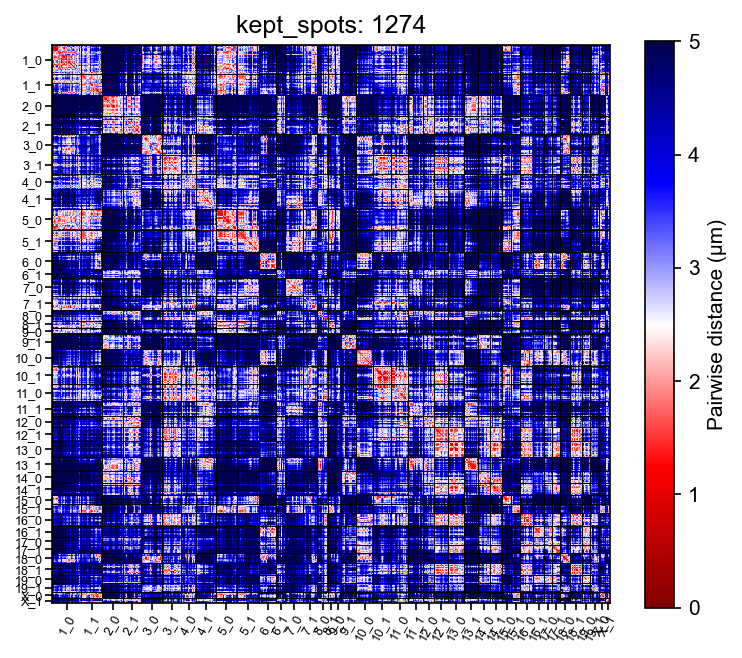

In [105]:
# test run one cell
%matplotlib inline
reload(decode)
_cell_ind = 10
decoder = decode.batch_decode_DNA(*decode_args[_cell_ind])

In [106]:
sc,dc = 0,0
for _ig, _group in enumerate(decoder.spot_groups):
    #print(_ig, _group.bits)
    if combo_channels[_group.bits[0]-1] == combo_channels[_group.bits[1]-1]:
        sc += 1
    else:
        dc += 1
print(sc,dc)

1185 904


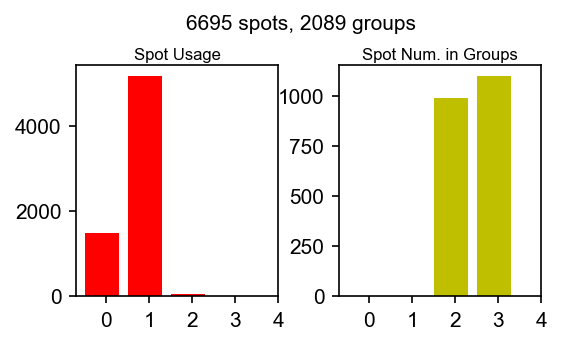

In [107]:
from ImageAnalysis3.figure_tools import plot_decode
reload(figure_tools.plot_decode)
plot_decode.plot_spot_stats(decoder.spot_groups, decoder.spot_usage,
                            show_image=False)

## visualize decoded spots

In [108]:
if not os.path.exists(decoder_folder):
    os.makedirs(decoder_folder)
    print(f"Creating decoder_folder: {decoder_folder}")
else:
    print(f"Use decoder_folder: {decoder_folder}")

decode_figure_folder = os.path.join(decoder_folder, 'Figures')
if not os.path.exists(decode_figure_folder):
    os.makedirs(decode_figure_folder)
    print(f"Creating decode_figure_folder: {decode_figure_folder}")
else:
    print(f"Use decode_figure_folder: {decode_figure_folder}")

Use decoder_folder: \\mendel\Mendel_SSD1\Pu_Temp\20220215-P_brain_CTP11-1000_CTP12_from0208\Decoder
Creating decode_figure_folder: \\mendel\Mendel_SSD1\Pu_Temp\20220215-P_brain_CTP11-1000_CTP12_from0208\Decoder\Figures


<IPython.core.display.Javascript object>


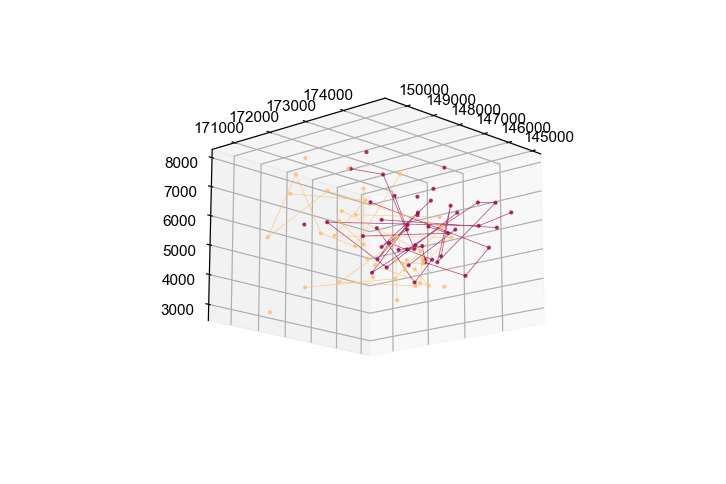

In [118]:
%matplotlib notebook

def rotate(angle):
     ax.view_init(azim=angle)
        
from matplotlib import animation

from matplotlib.cm import Reds, Blues, Spectral
fig = plt.figure(dpi=100)
ax = fig.add_subplot(projection='3d')

_zxys_list = decoder.chr_2_zxys_list['2']

for _ichr, _zxys in enumerate(_zxys_list):
    
    ax.scatter(_zxys[:,1], _zxys[:,2], _zxys[:,0],
               #cmap=Spectral, 
               color=Spectral(_ichr/(len(_zxys_list)+1)),
               #c=homolog_labels,
               alpha=0.7,
               s=3)

    ax.plot(_zxys[:,1], _zxys[:,2], _zxys[:,0], linewidth=0.5,
            alpha=0.7,
            color = Spectral( _ichr/(len(_zxys_list)+1) ) )
    
fig.show()

## 3.4 process all

In [ ]:
%%time
# old version
import multiprocessing as mp

print(len(decode_args))
with mp.Pool(44) as decode_pool:
    decode_results = decode_pool.starmap(decode.batch_decode_DNA, decode_args, chunksize=1)
    decode_pool.close()
    decode_pool.join()
    decode_pool.terminate()

14774


# 5. Summarize decoder

This step will detect all decoder files so it will merge fovs

In [18]:
#decoder_folder = os.path.join(save_folder, 'Decoder')
decoder_filenames = [os.path.join(decoder_folder, _fl) for _fl in os.listdir(decoder_folder) 
                     if '_Decoder.pkl' in _fl]
print(decoder_folder, len(decoder_filenames))

\\mendel\Mendel_SSD1\Pu_Temp\20220215-P_brain_CTP11-1000_CTP12_from0208\Decoder 1115


In [19]:
%%time
import multiprocessing as mp
load_args = [(_fl, 'chr_2_zxys_list') for _fl in decoder_filenames]
print(len(load_args))
with mp.Pool(44) as load_pool:
    all_chr_2_zxys_list = load_pool.starmap(decode.batch_load_attr, 
                                            load_args, chunksize=1)
    load_pool.close()
    load_pool.join()
    load_pool.terminate()

# summarize
decode_filenames = [_fl for _fl,_item in zip(decoder_filenames, all_chr_2_zxys_list) if _item is not None]
all_chr_2_zxys_list = [_item for _item in all_chr_2_zxys_list if _item is not None]
print(len(all_chr_2_zxys_list))

1115
1115
Wall time: 42.9 s


In [20]:
%%time
import multiprocessing as mp
summary_args = [(_item, codebook_df) for _item in all_chr_2_zxys_list ]

print(len(summary_args))

with mp.Pool(44) as summary_pool: 
    all_zxys_list = summary_pool.starmap(decode.DNA_Merfish_Decoder.summarize_zxys_by_regions, 
                                         summary_args, chunksize=1)
    summary_pool.close()
    summary_pool.join()
    summary_pool.terminate()

1115
Wall time: 1min 17s


In [ ]:
fig, ax = plt.subplots()

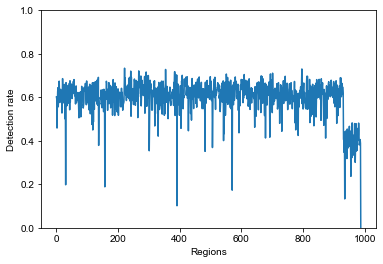

In [22]:
all_zxys = np.concatenate(all_zxys_list)
loss_rates = np.mean(np.isnan(all_zxys).any(2), axis=0)
plt.figure()
plt.plot(1-loss_rates)
plt.ylim([0,1])
plt.xlabel('Regions')
plt.ylabel('Detection rate')
plt.show()

plt.gcf().subplots_adjust(bottom=0.1, left=0.1, right=0.9,)
if save_figure:
    fig.savefig(os.path.join(figure_folder, 'all_contact_map.png'), transparent=True)
fig.show()



In [23]:
%%time
from scipy.spatial.distance import cdist,pdist,squareform
from tqdm import tqdm

all_zxys = np.concatenate(all_zxys_list)
#all_zxys = np.array(decode_save_dict['zxys'])

all_distmaps = [squareform(pdist(_zxys)) for _zxys in tqdm(all_zxys)]

from ImageAnalysis3.classes import postanalysis
median_distmap = postanalysis.parallel_reduce_matrix(all_distmaps, function='nanmedian', axis=0,
                                                     num_threads=44)

100%|███████████████████████████████████████████████████████████████████| 2230/2230 [00:30<00:00, 73.25it/s]


Wall time: 2min 2s


In [24]:
%%time
all_contactmaps = np.array(all_distmaps) <= 0.5

contactmap = postanalysis.parallel_reduce_matrix(all_contactmaps, function='nanmean', axis=0,
                                                     num_threads=44)


Wall time: 40.1 s


In [25]:
save_figure = True
#figure_folder = os.path.join(save_folder, 'Figures_final')
figure_folder = os.path.join(decoder_folder, 'Figures_final')
if not os.path.exists(figure_folder):
    print(f"Create figure_folder: {figure_folder}")
    os.makedirs(figure_folder)
else:
    print(f"Use figure_folder: {figure_folder}")

Use figure_folder: \\mendel\Mendel_SSD1\Pu_Temp\20220215-P_brain_CTP11-1000_CTP12_from0208\Decoder\Figures_final


In [26]:
_ordered_chr_names = []
for _chr_name, _chr_reg_id in zip(codebook_df['chr'], codebook_df['chr_order']):
    if _chr_name not in _ordered_chr_names:
        _ordered_chr_names.append(_chr_name)
chr_2_indices = {_chr:np.array(codebook_df.loc[codebook_df['chr']==_chr].index)
                for _chr in np.unique(codebook_df['chr'].values)}

_labels_edges = np.array([0] + [np.max(chr_2_indices[_chr]) for _chr in _ordered_chr_names])

E:\Users\puzheng\AppData\anaconda3\lib\site-packages\ipykernel_launcher.py:8: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("Reds"))
  


<IPython.core.display.Javascript object>


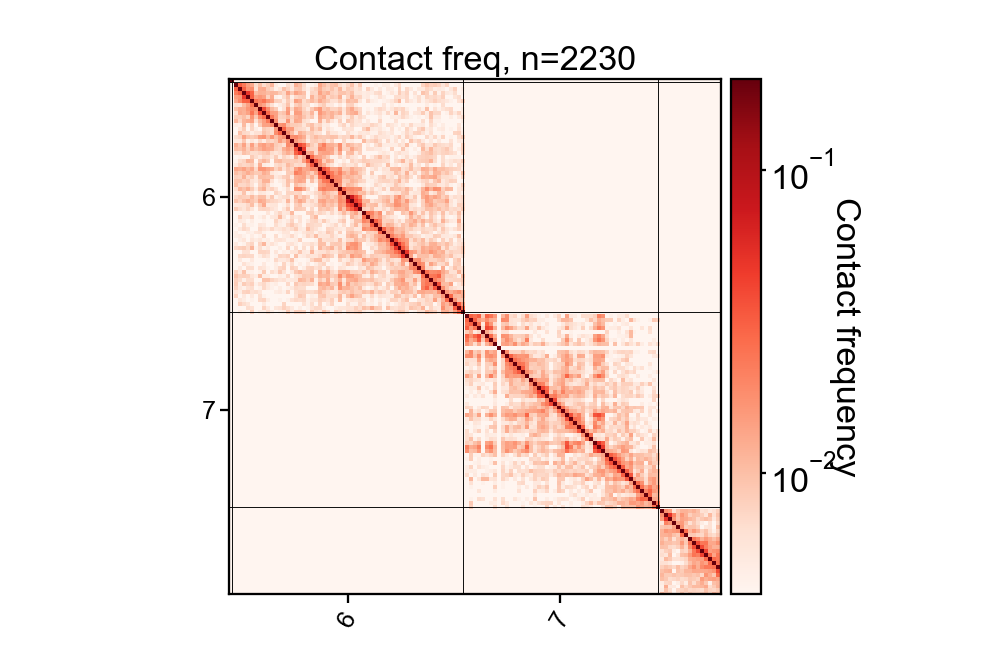

E:\Users\puzheng\Documents\ImageAnalysis3\figure_tools\distmap.py:39: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  vmin=min(color_limits), vmax=max(color_limits), **imshow_kwargs)


In [43]:
from matplotlib.colors import LogNorm
from matplotlib import cm

contact_limits = [0.004, 0.2]
contact_norm = LogNorm(vmin=np.min(contact_limits), 
                       vmax=np.max(contact_limits))
contact_cmap = cm.get_cmap('Reds')
contact_cmap.set_bad(color=[0.,0.,0.,1])

fig, ax = plt.subplots(figsize=(3,2), dpi=300)

ia.figure_tools.distmap.plot_distance_map(
    contactmap, 
    cmap=contact_cmap,
    color_limits=contact_limits,
    color_norm=contact_norm,
    colorbar_labels='Contact frequency',
    ax=ax,
)

ax.set_title(f'Contact freq, n={len(all_distmaps)}', fontsize=7.5, pad=2)

ax.set_xticks((_labels_edges[1:] + _labels_edges[:-1])/2)
ax.set_xticklabels(_ordered_chr_names, fontsize=5.5, rotation=60,)
ax.set_yticks((_labels_edges[1:] + _labels_edges[:-1])/2)
ax.set_yticklabels(_ordered_chr_names, fontsize=5.5, )

ax.hlines(_labels_edges, 0, len(median_distmap), color='black', linewidth=0.2)
ax.vlines(_labels_edges, 0, len(median_distmap), color='black', linewidth=0.2)

plt.gcf().subplots_adjust(bottom=0.1, left=0.1, right=0.9,)
if save_figure:
    fig.savefig(os.path.join(figure_folder, 'all_contact_map.png'), transparent=True)
fig.show()


<IPython.core.display.Javascript object>


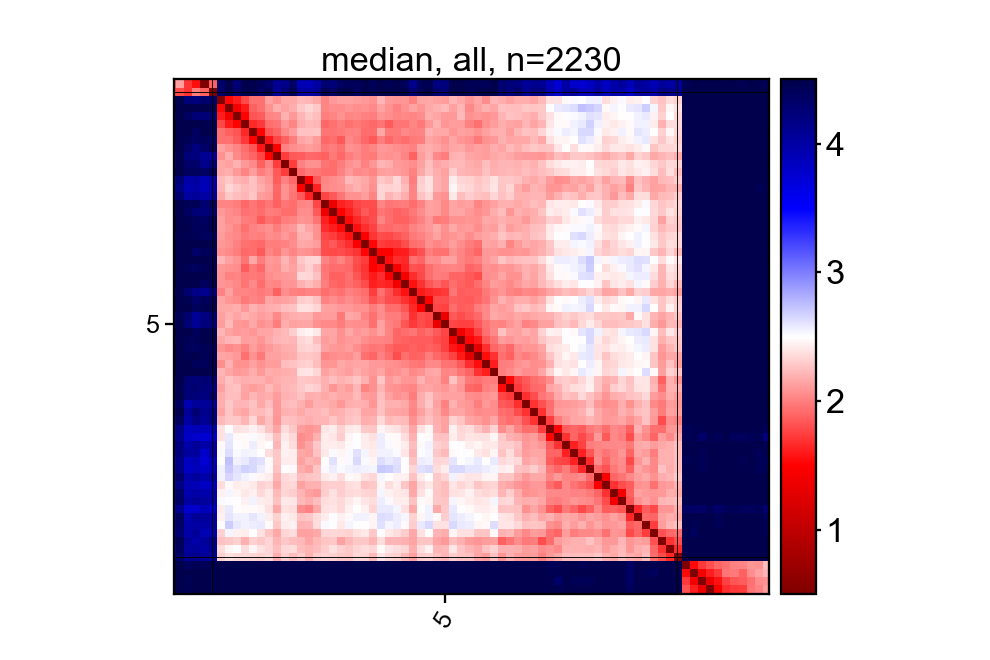

In [39]:
%matplotlib notebook

fig, ax = plt.subplots(figsize=(3,2), dpi=300)

ia.figure_tools.distmap.plot_distance_map(median_distmap, color_limits=[0.5,4.5],
                                          ax=ax,
                                          )
ax.set_title(f'median, all, n={len(all_distmaps)}', fontsize=7.5, pad=2)

ax.set_xticks((_labels_edges[1:] + _labels_edges[:-1])/2)
ax.set_xticklabels(_ordered_chr_names, fontsize=5.5, rotation=60,)
ax.set_yticks((_labels_edges[1:] + _labels_edges[:-1])/2)
ax.set_yticklabels(_ordered_chr_names, fontsize=5.5, )

ax.hlines(_labels_edges, 0, len(median_distmap), color='black', linewidth=0.2)
ax.vlines(_labels_edges, 0, len(median_distmap), color='black', linewidth=0.2)

plt.gcf().subplots_adjust(bottom=0.1, left=0.1, right=0.9,)
if save_figure:
    fig.savefig(os.path.join(figure_folder, 'all_median_distmap.png'), transparent=True)
fig.show()